In [1]:
from datetime import datetime
from PvGis import PvGis
import numpy as np
import pandas as pd
import json
import matplotlib
import rasterio
from rasterio.plot import show
import rioxarray as rxr
from osgeo import gdal
import csv
import math

In [2]:
# Create PvGis object and set its inputs
pvGis = PvGis()
pvGis.latitude = 37.097
pvGis.longitude = -2.365
pvGis.start_date = datetime(2016, 6, 1, 00, 00, 00)
pvGis.end_date = datetime(2016, 6, 15, 23, 59, 59)
pvGis.rad_database = 'PVGIS-CMSAF'

# Get data
pvGis.request_hourly_time_series()

# Save weather data to a CSV file
#pvGis.save_csv('weather_data.csv')

# Get Pandas DataFrame
df_pv = pvGis.pandas_data_frame()

In [3]:
#Read in chemical plants
df_chem = pd.read_csv('Data/chemicalparksv2.csv', sep=';', encoding='latin-1')

#Read in emissions and convert to csv
df_emissions = pd.read_json('Data/emissions.json')
co2_data = df_emissions.iloc[5,1]
co_data = df_emissions.iloc[5,2]

emissions = []

for plant in co2_data:
    emissions.append(
        {
            'FacilityName': plant['properties']['FacilityName'],
            'CountryName': plant['properties']['CountryName'],
            'ReportingYear':  plant['properties']['ReportingYear'],
            'FacilityDetails': plant['properties']['FacilityDetails'],
            'MTonnes': plant['properties']['MTonnes'],
            'Activity':  plant['properties']['NACEMainEconomicActivityName'],
            'Pollutant': plant['properties']['PollutantName'],
            'Co-ordinates':  plant['geometry']['coordinates']
            
        })
    
df_emissions = pd.DataFrame(emissions)
df_emissions.to_csv('Data/emissions.csv')

In [4]:
#Read in emissions
df_emissions = pd.read_csv('Data/emissions.csv')

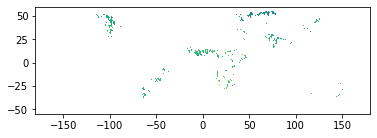

1
(13800, 43200)
EPSG:4326


In [5]:
#RasterIO read in data
fp = r'Data/global potential/derived/PVOUT_level1.tif'
dataset = rasterio.open(fp)
show(dataset)

#No. of bands
print(dataset.count)

# Image resolution
print(dataset.shape)

# Coordinate Reference System
print(dataset.crs)


In [6]:
from osgeo import gdal
g = gdal.Open('Data/global potential/derived/PVOUT_level1.tif')

#gt = tif.GetGeotransform()

x_size, y_size, n_bands = g.RasterXSize, g.RasterYSize, g.RasterCount

In [7]:
#Rioxarray to get data from tif
fp = r'Data/global potential/derived/PVOUT_level1.tif'
dataset = rxr.open_rasterio(fp)
dataset

<xarray.DataArray (band: 1, y: 13800, x: 43200)>
[596160000 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * y            (y) float64 60.0 59.99 59.98 59.97 ... -54.98 -54.99 -55.0
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    spatial_ref  int32 0
Attributes:
    COLOR_TABLE_RULES_COUNT:   255
    COLOR_TABLE_RULE_RGB_0:    0.000000e+00 2.646784e-02 68 1 84 68 2 86
    COLOR_TABLE_RULE_RGB_1:    2.646784e-02 5.293568e-02 68 2 86 69 4 87
    COLOR_TABLE_RULE_RGB_10:   2.648134e-01 2.912813e-01 71 16 99 71 17 100
    COLOR_TABLE_RULE_RGB_100:  2.647864e+00 2.674332e+00 42 118 142 42 119 142
    COLOR_TABLE_RULE_RGB_101:  2.674332e+00 2.700800e+00 42 119 142 42 120 142
    COLOR_TABLE_RULE_RGB_102:  2.700800e+00 2.727268e+00 42 120 142 41 121 142
    COLOR_TABLE_RULE_RGB_103:  2.727268e+00 2.753736e+00 41 121 142 41 122 142
    COLOR_TABLE_RULE_RGB_104:  2.753736e+00 2.780203e+00 41 122 142 41 123 142
    COLOR_TABLE_RULE_RGB_105:  2.780203e+00 2.806739e+00 41 123 142 40 124 142
    COLOR_TABLE_RULE_RGB_106:  2.806739e+00 2.833207e+00 40 124 142 40 125 142
    COLOR_TABLE_RULE_RGB_107:  2.833207e+00 2.859674e+00 40 125 142 39 126 142
    COLOR_TABLE_RULE_RGB_108:  2.859674e+00 2.886142e+00 39 126 142 39 127 142
    COLOR_TABLE_RULE_RGB_109:  2.886142e+00 2.912610e+00 39 127 142 39 128 142
    COLOR_TABLE_RULE_RGB_11:   2.912813e-01 3.177491e-01 71 17 100 71 19 101
    COLOR_TABLE_RULE_RGB_110:  2.912610e+00 2.939078e+00 39 128 142 38 129 142
    COLOR_TABLE_RULE_RGB_111:  2.939078e+00 2.965613e+00 38 129 142 38 130 142
    COLOR_TABLE_RULE_RGB_112:  2.965613e+00 2.992081e+00 38 130 142 38 130 142
    COLOR_TABLE_RULE_RGB_113:  2.992081e+00 3.018549e+00 38 130 142 37 131 142
    COLOR_TABLE_RULE_RGB_114:  3.018549e+00 3.045017e+00 37 131 142 37 132 142
    COLOR_TABLE_RULE_RGB_115:  3.045017e+00 3.071485e+00 37 132 142 37 133 142
    COLOR_TABLE_RULE_RGB_116:  3.071485e+00 3.097953e+00 37 133 142 36 134 142
    COLOR_TABLE_RULE_RGB_117:  3.097953e+00 3.124488e+00 36 134 142 36 135 142
    COLOR_TABLE_RULE_RGB_118:  3.124488e+00 3.150956e+00 36 135 142 35 136 142
    COLOR_TABLE_RULE_RGB_119:  3.150956e+00 3.177424e+00 35 136 142 35 137 142
    COLOR_TABLE_RULE_RGB_12:   3.177491e-01 3.442170e-01 71 19 101 72 20 103
    COLOR_TABLE_RULE_RGB_120:  3.177424e+00 3.203891e+00 35 137 142 35 138 141
    COLOR_TABLE_RULE_RGB_121:  3.203891e+00 3.230359e+00 35 138 141 34 139 141
    COLOR_TABLE_RULE_RGB_122:  3.230359e+00 3.256827e+00 34 139 141 34 140 141
    COLOR_TABLE_RULE_RGB_123:  3.256827e+00 3.283295e+00 34 140 141 34 141 141
    COLOR_TABLE_RULE_RGB_124:  3.283295e+00 3.309830e+00 34 141 141 33 142 141
    COLOR_TABLE_RULE_RGB_125:  3.309830e+00 3.336298e+00 33 142 141 33 143 141
    COLOR_TABLE_RULE_RGB_126:  3.336298e+00 3.362766e+00 33 143 141 33 144 141
    COLOR_TABLE_RULE_RGB_127:  3.362766e+00 3.389234e+00 33 144 141 33 145 140
    COLOR_TABLE_RULE_RGB_128:  3.389234e+00 3.415702e+00 33 145 140 32 146 140
    COLOR_TABLE_RULE_RGB_129:  3.415702e+00 3.442170e+00 32 146 140 32 146 140
    COLOR_TABLE_RULE_RGB_13:   3.442170e-01 3.706848e-01 72 20 103 72 22 104
    COLOR_TABLE_RULE_RGB_130:  3.442170e+00 3.468705e+00 32 146 140 32 147 140
    COLOR_TABLE_RULE_RGB_131:  3.468705e+00 3.495173e+00 32 147 140 31 148 140
    COLOR_TABLE_RULE_RGB_132:  3.495173e+00 3.521641e+00 31 148 140 31 149 139
    COLOR_TABLE_RULE_RGB_133:  3.521641e+00 3.548108e+00 31 149 139 31 150 139
    COLOR_TABLE_RULE_RGB_134:  3.548108e+00 3.574576e+00 31 150 139 31 151 139
    COLOR_TABLE_RULE_RGB_135:  3.574576e+00 3.601044e+00 31 151 139 31 152 139
    COLOR_TABLE_RULE_RGB_136:  3.601044e+00 3.627512e+00 31 152 139 31 153 138
    COLOR_TABLE_RULE_RGB_137:  3.627512e+00 3.654047e+00 31 153 138 31 154 138
    COLOR_TABLE_RULE_RGB_138:  3.654047e+00 3.680515e+00 31 154 138 30 155 138
    COLOR_TABLE_RULE_RGB_139:  3.680515e+00 3.706983e+00 30 155 138 30 156 137
    COLOR_TABLE_RULE_RGB_14:

In [17]:
lons = np.linspace(-180,180,361)
lats = np.linspace(-90,90,181)

count_vals = 0

lons_final = []
lats_final = []
vals = []

with rasterio.open('Data/global potential/derived/PVOUT_level1.tif') as src:    
    for i in lons:                                              #goes through every latitude for one longitude
        for j in lats:                                         #then moves onto next longitude
            for val in src.sample(zip([i], [j])):
                if val > 0 and val < 10:
                    count_vals +=1
                    lons_final.append(i)
                    lats_final.append(j)
                    vals.append(val[0]*365)
                    
vals_wind = []

with rasterio.open('Data/power_density/gwa3_250_power-density_50m.tif') as src:    
            for val in src.sample(zip(lons_final, lats_final)):
                if val > 0:
                    vals_wind.append(val[0])
                
                  
print(str(round(count_vals/(len(lons)*len(lats))*100,2)) +'%')
print(len(lons_final))


lons_lats = zip(lons_final, lats_final, vals, vals_wind)
lons_lats = tuple(lons_lats)

with open('Data/level1renewable.csv','w', newline='') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['Longitude', 'Latitude', 'Solar Energy Potential','Wind Power Density'])
    csv_out.writerows(lons_lats)

9.14%
5970


In [18]:
df_ren = pd.read_csv('Data/level1renewable.csv')
df_ren['Solar Array Size'] = 100 / df_ren['Solar Energy Potential']    #[kWp]
df_ren['Solar Array Cost'] = df_ren['Solar Array Size'] * 700    #[Eur]
df_ren['Wind Turbine Power'] = df_ren['Wind Power Density']*0.4*(50*50*math.pi)/1e6
df_ren['No. of Turbines']  = 100/df_ren['Wind Turbine Power']
df_ren['Wind Capex'] = df_ren['No. of Turbines'] * 2000000
df_ren

,Longitude,Latitude,Solar Energy Potential,Wind Power Density,Solar Array Size,Solar Array Cost,Wind Turbine Power,No. of Turbines,Wind Capex
0,-159.0,56.0,1063.974986,472.33026,0.093987,65.791020,1.483869,67.391381,1.347828e+08
1,-159.0,59.0,1079.305006,369.35553,0.092652,64.856551,1.160365,86.179808,1.723596e+08
2,-135.0,57.0,917.975038,958.34094,0.108935,76.254797,3.010717,33.214681,6.642936e+07
3,-128.0,55.0,999.004996,1433.11040,0.100100,70.069720,4.502249,22.211121,4.442224e+07
4,-126.0,55.0,1163.984960,77.40454,0.085912,60.138234,0.243174,411.228962,8.224579e+08
...,...,...,...,...,...,...,...,...,...
5965,174.0,-36.0,1325.315015,343.84467,0.075454,52.817631,1.080220,92.573744,1.851475e+08
5966,175.0,-39.0,1227.860030,146.18901,0.081443,57.009755,0.459266,217.738588,4.354772e+08
5967,175.0,-38.0,1220.925010,331.73700,0.081905,57.333579,1.042183,95.952482,1.919050e+08
5968,175.0,-37.0,1302.685002,310.05020,0.076765,53.735170,0.974051,102.663984,2.053280e+08


In [10]:
h2_demand = 1   #[kt/yr]
elec_eff = 0.81
h2_demand_hourly = h2_demand*1000*1000/(5000)
h2_demand_hourly

200.0

In [11]:
elec_demand = h2_demand_hourly * 39/elec_eff
elec_demand

9629.62962962963

In [12]:
h2_demand_hourly = h2_demand * 1000 * 1000 / 6000     #[kg/hr]
elec_demand = h2_demand_hourly * 39/0.81        #[kW]
elec_demand_yearly = h2_demand * 1000 *  39/0.81      #[MWh/yr]
elec_demand2 = elec_demand_yearly/6000
print(elec_demand)
print(elec_demand2)
print(elec_demand_yearly)

8024.691358024691
8.024691358024691
48148.148148148146


In [13]:
8024*6000

48144000